# Лабораторная работа №2

In [10]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline

import os
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

### Импорт данных

In [6]:
df = pd.read_csv("Econom_Cities_data.csv", sep=";", index_col='City')
print(df.shape)
print(df.head())

(48, 3)
           Work Price Salary
City                        
Amsterdam  1714  65,6     49
Athens     1792  53,8   30,4
Bogota     2152  37,9   11,5
Bombay     2052  30,3    5,3
Brussels   1708  73,8   50,5


Приведем Price и Salary к числу 

In [4]:
df["Price"]  = pd.to_numeric(df["Price"].astype(str).str.replace(",", "."))
df["Salary"] = pd.to_numeric(df["Salary"].astype(str).str.replace(",", "."))

Проверяем чтобы все данные теперь были числовые

In [7]:
df.describe()

,Work
count,48.000000
mean,1384.958333
std,2404.897007
min,-9999.000000
25%,1740.750000
50%,1834.500000
75%,1972.750000
max,2375.000000


### Убираем выбросы

In [5]:
# Определяем квартили и межквартильный размах
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

# определяем нижнюю и верхнюю границы
lower = Q1 - 3.0 * IQR
upper = Q3 + 3.0 * IQR

# Определяем выбросы 
outlier_mask = ((df < lower) | (df > upper)).any(axis=1)

#  Отдельно сохраним выбросы и чистые данные 
outliers = df[outlier_mask]
df_clean = df[~outlier_mask]

# Вывод информации 
print(f"Количество выбросов: {outliers.shape[0]}")
print("Индексы (города) с выбросами:")
print(outliers.index.tolist())

print()
print('Дальше используем датафрейм df_clean')

Количество выбросов: 2
Индексы (города) с выбросами:
['Cairo', 'Jakarta']

Дальше используем датафрейм df_clean


### Стандартизируем данные

т.к. данные находятся в разных диапазонах, нужна стандартизация

Формула стандартизации: $z = \frac{x - \text{mean}}{\text{std}}$

In [8]:
scaler = StandardScaler() 
X_scaled = scaler.fit_transform(df_clean) # Сразу изучаем и преобразовываем данные

X = pd.DataFrame(X_scaled, index=df_clean.index, columns=df_clean.columns)
print(X.round(2))

                Work  Price  Salary
City                               
Amsterdam      -0.96  -0.21    0.39
Athens         -0.51  -0.77   -0.37
Bogota          1.58  -1.52   -1.15
Bombay          1.00  -1.88   -1.40
Brussels       -1.00   0.17    0.45
Buenos_Aires    0.53  -0.66   -1.10
Caracas         0.93  -0.43   -1.17
Chicago         0.26   0.18    0.91
Copenhagen     -0.94   1.00    0.95
Dublin         -0.70   0.28    0.08
Dusseldorf     -1.08   0.40    0.84
Frankfurt      -1.33   0.21    0.85
Geneva          0.00   1.22    2.07
Helsinki       -1.23   2.06    1.10
Hong_Kong       2.87  -0.30   -0.48
Houston         0.57   0.09    0.28
Johannesburg    0.38  -0.90   -0.63
Kuala_Lumpur    1.66  -1.26   -1.21
Lagos          -0.54  -1.18   -1.50
Lisbon         -0.80  -0.66   -0.85
London         -0.83   0.67    0.27
Los_Angeles     1.09   0.46    1.05
Luxembourg     -0.65   0.05    1.29
Madrid         -0.99   1.12    0.43
Manila          2.25  -1.42   -1.45
Mexico_City     0.37  -0.96 

### Кластеризация

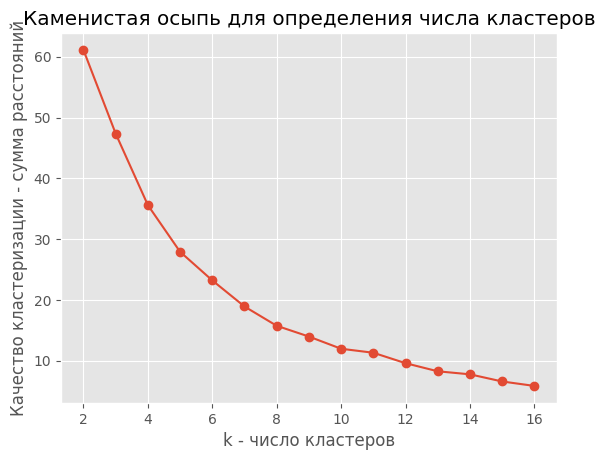

In [12]:
# Выбираем число кластеров. От 2 до 16
K = range(2, 17)

# Строим 15 моделей с разным числом кластеров
dist = [KMeans(n_clusters=k, random_state=42, n_init=10, verbose=0).fit(X).inertia_ for k in K]

# Строим график каменистая осыпь
plt.plot(K, dist, marker='o')

plt.xlabel('k - число кластеров')
plt.ylabel('Качество кластеризации - сумма расстояний')
plt.title('Каменистая осыпь для определения числа кластеров')
plt.show()

По графику видно, что при увеличении числа кластеров от двух до четырех наблюдается значительный прирост качества разбиения. 

После четвертого кластера улучшение становится менее существенно

Остановимся на 4х кластерах

In [16]:
# строим модель
model = KMeans(n_clusters=4, random_state=42, max_iter=300, n_init=10, verbose=0)
model.fit(X)

,n_clusters,4
,init,'k-means++'
,n_init,10
,max_iter,300
,tol,0.0001
,verbose,0
,random_state,42
,copy_x,True
,algorithm,'lloyd'


In [20]:
#  Добавляем столбец cluster к таблице данных
df_clean['cluster'] = model.labels_

In [21]:
#  Средние значения в каждом кластере
df_clean.groupby('cluster').mean()

,Work,Price,Salary
cluster,,,
0,1801.235294,75.758824,55.005882
1,2133.500000,54.170000,16.080000
2,1763.750000,104.550000,67.587500
3,1855.454545,50.781818,16.590909


In [22]:
#  Выведем состав каждого кластера
df_clean['cluster'].sort_values()

City
Amsterdam         0
Brussels          0
Chicago           0
Dublin            0
Houston           0
Frankfurt         0
Dusseldorf        0
Los_Angeles       0
Montreal          0
London            0
New_York          0
Milan             0
Luxembourg        0
Vienna            0
Sydney            0
Paris             0
Toronto           0
Bombay            1
Kuala_Lumpur      1
Taipei            1
Manila            1
Caracas           1
Hong_Kong         1
Bogota            1
Panama            1
Singpore          1
Tel_Aviv          1
Oslo              2
Copenhagen        2
Madrid            2
Geneva            2
Helsinki          2
Tokyo             2
Zurich            2
Stockholm         2
Lagos             3
Johannesburg      3
Lisbon            3
Buenos_Aires      3
Athens            3
Nicosia           3
Nairobi           3
Mexico_City       3
Rio_de_Janeiro    3
Seoul             3
San_Paulo         3
Name: cluster, dtype: int32

### Вывод

Исходя из полученных результатов, можно выделить четыре экономических типа городов:

**Кластер 0 - развитые и сбалансированные**

**Кластер 1 - недорогие, но низкооплачиваемые. Преобладает дешевая рабочая сила**

**Кластер 2 - богатые и дорогие города с высоким уровнем жизни**

**Кластер 3 - относительно дешёвые и менее развитые города с невысокими доходами**